## K-armed bandit problem

This is the original formulation of the k-armed bandit problem, named after the slot machine, or "one-armed bandit". Only in this case there is not one lever, but k. Each choice of action corresponds to the lowering of one of the levers of the slot machine, and the rewards are the payouts for hitting the jackpot.

<img src="media/bandits.png" width=500/>

## How to define a k-armed bandit?

### Let's create a k-armed bandit class
Each "arm" is characterized by average value and <b>reward_variance</b> - it determines the distribution from which the reward will be calculated. These average value are in turn generated from another distribution with average <b>mean</b> and <b>variance</b>. The player's <b>action</b> is to choose a arm - after choosing, he receives a reward from the distribution of the corresponding arm.

When initializing, we will specify:

<b>k</b> - the number of "arms" or the number of possible actions

<b>mean</b> - the average value for "arms" generating 

<b>variance</b> - variance for "arms" generating 

<b>reward_variance</b> - variance for calculating the reward for each "arm". We assume that they are the same for all arms

<img src="media/bandit_distribution.png" width=500/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class KArmedBandit:
    
    def __init__(self, k=10, mean=0, variance=1, reward_variance=1):
        
        self.k = k
        self.mean = mean
        self.variance = variance
        self.reward_variance = reward_variance
        self.clear()
    
    # method for getting reward, returns a random value from a random arm distribution
    def get_reward(self, arm):
        
        reward = np.random.normal(loc=self.arms_mean[arm], scale=self.reward_variance)
        return reward
    
    # method for reboot all "arms"
    def clear(self):
        self.arms_mean = [np.random.normal(loc=self.mean, scale=self.variance) for x in range(self.k)]

In [3]:
# we initialize one bandit
bandit = KArmedBandit(k=10)

## Reward distributions of 10-armed bandit after 100000 steps

Let's try to run the bandit a large number of times and remember at the same time on which arm what reward we received. This way we can see the 10 Gaussian distributions around the mean values that the bandit generated for each arm during initialization.

In [4]:
# now let's try to ask for a reward a large number of times, each time remembering the arm that gave us the result
N = 100000
arms = np.zeros(N)
rewards = np.zeros(N)
for i in range(N):
    arm = np.random.randint(bandit.k)
    arms[i] = arm
    rewards[i] = bandit.get_reward(arm)

### This histogram shows how often the reward values fell out when choosing different actions

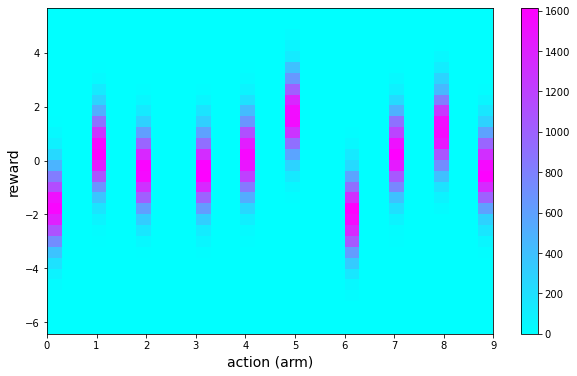

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
h = ax.hist2d(arms, rewards, bins=(30, 30), cmap=plt.cm.cool);
ax.set_xlabel("action (arm)", fontsize=14)
ax.set_ylabel("reward", fontsize=14)
fig.colorbar(h[3], ax=ax)

## Action-value methods

Let denote the true (actual) value of action a as <b>q(a)</b>, and the
estimated value on the <b>t</b> time step as <b>Qt(a)</b>. One natural
way to estimate this is by averaging the rewards actually received when the
action was selected:

<img src="media/action_value.png" width=300/>

The simplest action selection rule is to select the action (or one of the
actions) with highest estimated action value, that is, to select at step <b>t</b> one
of the greedy actions, <b>A*t</b>, for which 
    
<b>Qt(A*t) = max(Qt(a))</b>

This <b>greedy</b> action
selection method can be written as

<img src="media/action.png" width=200/>

## Greedy agent

Create Greedy agent class. On initialization, the agent takes an environment (a bandit) and figures out how many possible actions it has. Then an array of values of each action <b>Q</b> is initialized. We also need a count of the number of choices each action has to estimate its value.

In [47]:
class GreedyAgent:
    
    def __init__(self, bandit, **kwargs):
        
        self.bandit = bandit
        self.actions = bandit.k
        self.Q = np.zeros(self.actions)
        self.action_choices = np.zeros(self.actions)
    
    # Choice an action (greedy).
    def action_choice(self):
        
        Q_max = self.Q.max()
        probably_actions = np.where(self.Q == Q_max)[0]
        action = np.random.choice(probably_actions)
        
        return action
    
    # Perform an action.
    def action(self):
                
        action = self.action_choice()
        reward = bandit.get_reward(action)
        self.update_Q(action, reward)
        
        return action, reward
    
    # Action value update function. 
    # We do not need to keep in mind all the previous rewards, the last one is enough, which is easy to prove mathematically.
    def update_Q(self, action, reward):
        
        self.action_choices[action] += 1       
        self.Q[action] += reward/self.action_choices[action]
        #print(self.Q)
    
    
    

## Secondary functions

There will be a function to run experiments. As input, it takes the <b>environment</b> model, the <b>agent</b> model, the number of agents and the number of steps that each agent will live in the environment.

For each step, we will evaluate two parameters - the <b>average reward</b> received by the agents and the <b>probability of best action</b> - part of the agents who chose the best action (we both know what this action is, since we fully know the environment)

Naturally, the faster these values approach the maximum, the better the agent works.

In [7]:
def run_experiment(agent_class, enviroment, label='Greedy', N_steps = 100, N_agents = 100, **agent_args):
    
    # init arrays for rewards and actions history
    rewards = np.zeros(N_steps)
    best_actions = np.zeros(N_steps)
    
    for j in range(N_agents):
        
        # for each agent reboot enviroment (bandit)
        enviroment.clear()
        agent = agent_class(enviroment, **agent_args)
        
        # denote best action (arm with maximum mean of reward distribution)
        best_action = np.argmax(bandit.arms_mean)
        print(f'Agents: {j+1}/{N_agents}', end = '\r')
        for i in range(N_steps):
            
            # for each step agent make decision and recieve reward
            action, reward = agent.action()
            
            #updaterewards and actions history
            rewards[i] += reward
            if action==best_action:
                best_actions[i] +=1

    avg_rewards = rewards/N_agents
    best_action_prob = best_actions/N_agents
    
    return {'rewards': avg_rewards, 'actions': best_action_prob, 'label': label}

# function for drawing result graphs
def plot_results(results):
    x = np.arange(len(results[0]['rewards']))
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))
    for result in results:
        ax1.plot(x, result['rewards'], label=result['label'])
        ax2.plot(x, result['actions'], label=result['label'])
    ax1.set_ylabel("average reward", fontsize=14)
    ax2.set_ylabel("probability of best action", fontsize=14)
    ax2.set_xlabel("steps", fontsize=14)

    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14);

In [8]:
# Run 1000 greedy agents on 1000 steps
results_greedy = run_experiment(GreedyAgent, KArmedBandit(), N_steps = 1000, N_agents = 1000)

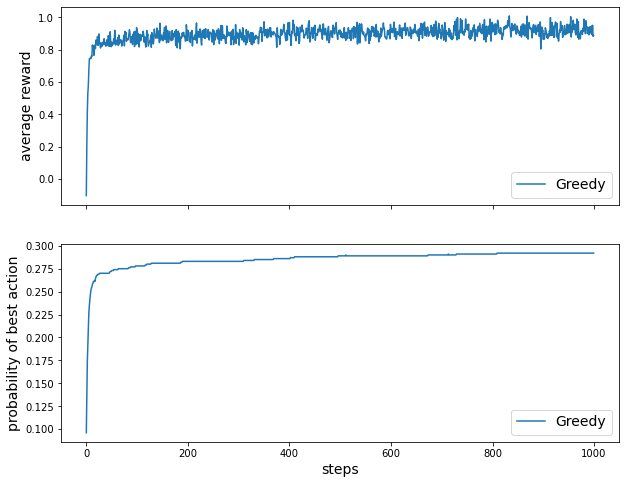

In [9]:
plot_results([results_greedy])

## Epsilon-Greedy Agent

Let's try to modify the agent a little. Now there is some value of the <b>epsilon</b> probability with which our <b>greedy agent</b> will choose not the best action in his opinion, but any action with equal probability.

This will allow the agent to better <b>explore</b> the environment, instead of immediately <b>exploite</b> the first knowledge gained.

In [48]:
# Let's just inherit the class from the greedy agent and change the action selection function a bit
class EpsilonGreedyAgent(GreedyAgent):
    
    def __init__(self, enviroment, **agent_args):
        super().__init__(enviroment)
        self.epsilon = agent_args['epsilon']
        
    def action_choice(self):
        
        # agent choises random action with epsilon probability 
        if np.random.random_sample() > self.epsilon:
            return super().action_choice()
        else:
            return np.random.randint(self.actions)

In [11]:
# Let's do the same experiment with an agent who chooses a random action 10% of the time
results_eps_greedy_01 = run_experiment(EpsilonGreedyAgent, KArmedBandit(), 'e-Greedy e=0.1', 
                                                                    N_steps = 1000, N_agents = 1000, epsilon=0.1)
# Let's do the same experiment with an agent who chooses a random action 1% of the time
results_eps_greedy_001 = run_experiment(EpsilonGreedyAgent, KArmedBandit(), 'e-Greedy e=0.01', 
                                                                    N_steps = 1000, N_agents = 1000, epsilon=0.01)

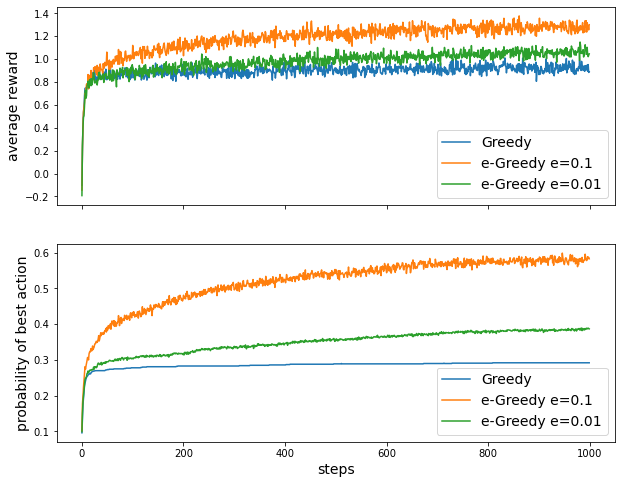

In [12]:
plot_results([results_greedy, results_eps_greedy_01, results_eps_greedy_001])

## Step-Size parameter

The averaging methods discussed so far are appropriate in a stationary environment, but not if the bandit is changing over time. As noted earlier, we often encounter reinforcement learning problems that are effectively nonstationary. In such cases it makes sense to weight recent rewards more heavily than long-past ones. One of the most popular ways of doing this is to use a constant step-size parameter.

<img src="media/step_size.png" width=300/>

## Optimistic Initial Values

All the methods we have discussed so far are dependent to some extent on
the initial action-value estimates, <b>Q</b>. In the language of statistics, these
methods are <b>biased</b> by their initial estimates.

But we can artificially raise the initial score <b>Q</b>. Then the agent will be <i>"dissatisfied"</i> with the rewards for a longer time, which will force him to continue the search and find more optimal actions.

In [67]:
# init opstimistic agent with step-size parameter for Q updating

class OptimisticGreedyAgent(GreedyAgent):
    
    def __init__(self, enviroment, **agent_args):
        
        super().__init__(enviroment)
        
        # init optimistic Q and step-size parameter
        self.Q = np.ones(self.actions) * agent_args['Q1']
        self.alpha = agent_args['alpha']
    
    
    def update_Q(self, action, reward):
        
        # change Q updating with alpha step-size parameter
        self.action_choices[action] += 1       
        self.Q[action] = self.Q[action] + self.alpha * (reward - self.Q[action])


In [69]:
# Let's do the experiment with an optimistic agent with Q1=5
results_optimistic_greedy_5 = run_experiment(OptimisticGreedyAgent, KArmedBandit(), 'Optimistic Greedy, Q1=5', 
                                                                    N_steps = 1000, N_agents = 1000, Q1=5, alpha=0.1)

In [70]:
# Let's do the experiment with an optimistic agent with Q1=3
results_optimistic_greedy_3 = run_experiment(OptimisticGreedyAgent, KArmedBandit(), 'Optimistic Greedy, Q1=3', 
                                                                    N_steps = 1000, N_agents = 1000, Q1=3, alpha=0.1)

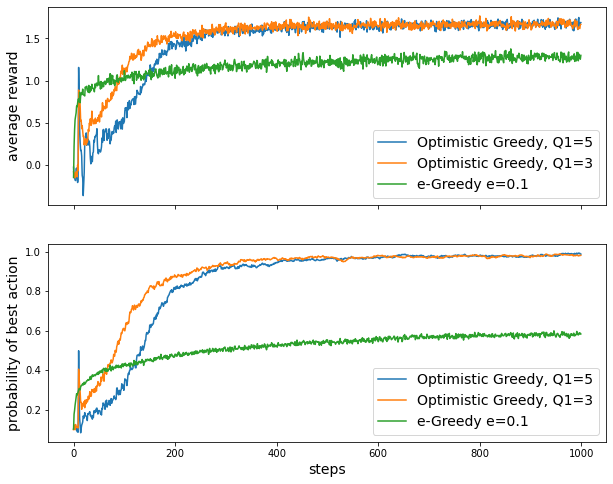

In [71]:
plot_results([results_optimistic_greedy_5, results_optimistic_greedy_3, results_eps_greedy_01])

## Upper-Confidence-Bound Action Selection

Exploration is needed because the estimates of the action values are uncertain.
The greedy actions are those that look best at present, but some of the other
actions may actually be better. ε-greedy action selection forces the non-greedy
actions to be tried, but indiscriminately, with no preference for those that are
nearly greedy or particularly uncertain. It would be better to select among
the non-greedy actions according to their potential for actually being optimal,
taking into account both how close their estimates are to being maximal and
the uncertainties in those estimates. One effective way of doing this is to select
actions as

<img src="media/ucb.png" width=300/>

In [91]:
# init UCB agent
class UCBAgent(GreedyAgent):
    
    def __init__(self, enviroment, **agent_args):
        
        super().__init__(enviroment)
        
        # init C parameter, history of action choosed and time
        self.c = agent_args['C']
        self.t = 0
        self.action_history = np.zeros(self.actions)
        
    
    # Choice an action with Upper-Confidence-Bound selection
    def action_choice(self):
        
        # check zero-choised actions
        if 0 in self.action_history:
            probably_actions = np.where(self.action_history == 0)[0]
        else:
            A = np.zeros(self.actions)
            
            # update value of A - Q with Upper-Confidence-Bound
            for i in range(self.actions):
                if self.action_history[i] == 0:
                    A[i] = self.Q[i]
                else:
                    A[i] = self.Q[i] + self.c * np.sqrt(np.log(self.t)/self.action_history[i])

            A_max = A.max()
            probably_actions = np.where(A == A_max)[0]
            
        action = np.random.choice(probably_actions)
        
        # update time step and actions history
        self.action_history[action] += 1
        self.t += 1
        
        return action

In [92]:
# Let's do the experiment with an UCB agent with C=2
results_UCB_agent = run_experiment(UCBAgent, KArmedBandit(), 'Upper-Confidence-Bound, C=2', 
                                                                    N_steps = 1000, N_agents = 1000, C=2)

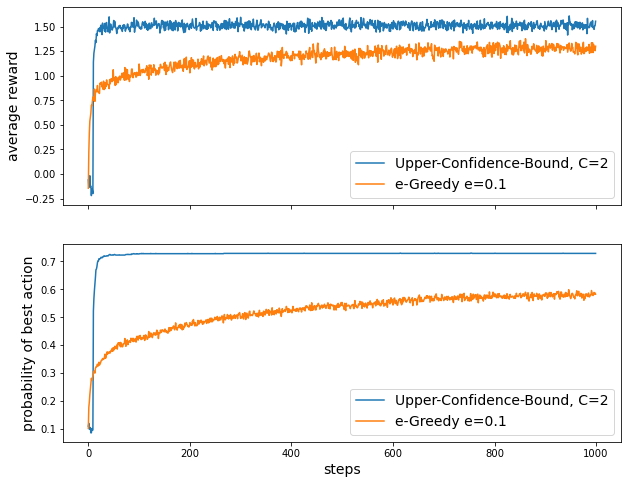

In [93]:
plot_results([results_UCB_agent, results_eps_greedy_01])

## Conclusion

This notebook discusses the main methods for solving the multi-armed bandit problem. Gradient bandit methods have been omitted here as well as Bayesian methods. You can learn about them in other sources and try to implement them yourself!